In [7]:
# import libraries 
import matplotlib.pyplot as plt
%matplotlib inline
import os,sys, time, glob
sys.path.append('models/')
import numpy as np

import skimage
import scipy.io
import cv2 as cv
from helper import model_builder
from models.u_net2 import Unet as Unet
from ensemble import *
from utils import *



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sample images

Text(0.5, 1.0, 'Lensed Image')

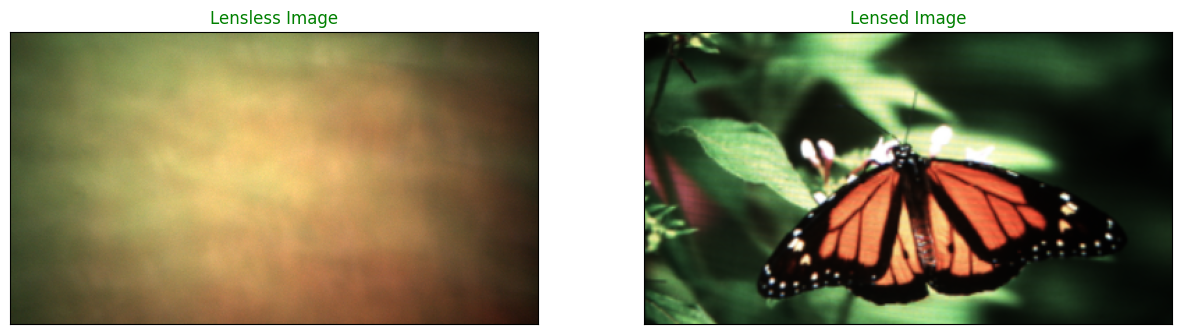

In [8]:
img_index=7
#img_index = 1
file_path_diffuser = os.path.join('sample_images', 'diffuser')
file_path_lensed = os.path.join('sample_images', 'lensed')
files = glob.glob(os.path.join(file_path_diffuser, '*.npy'))

# Extract the filename and construct the full path for both diffuser and lensed images correctly
filename = os.path.basename(files[img_index])
image_file_path = os.path.join(file_path_diffuser, filename)
label_file_path = os.path.join(file_path_lensed, filename)

# Load and transpose the numpy arrays
image_np = np.load(image_file_path).transpose((2, 0, 1))
label_np = np.load(label_file_path).transpose((2, 0, 1))

image = torch.tensor(image_np).unsqueeze(0)
label = torch.tensor(label_np).unsqueeze(0)

# Plot sample image: 
fig1, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(preplot(image_np)/np.max(image_np)); 
ax[1].imshow(preplot(label_np)); 
ax[0].set_xticks([]); ax[0].set_yticks([])
ax[1].set_xticks([]); ax[1].set_yticks([]) 
ax[0].set_title('Lensless Image',{'color':'g'})  
ax[1].set_title('Lensed Image',{'color':'g'})

## PSF

The shape of the diffuser is:(1080, 1920, 3)


Text(0.5, 1.0, 'PSF of the diffuser')

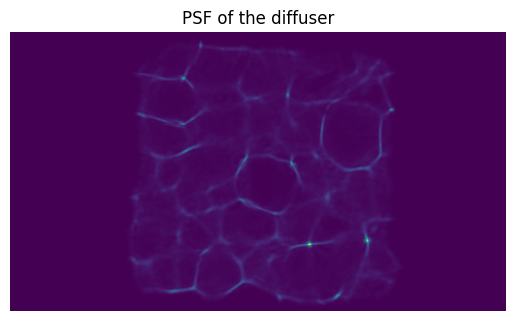

In [9]:
# Load PSF
#device agnostics
my_device='cuda:2' if torch.cuda.is_available() else 'cpu'
path_diffuser = 'sample_images/psf.tiff'
psf_diffuser = load_psf_image2(path_diffuser, downsample=1, rgb= False)
ds = 4   # Amount of down-sampling.
print('The shape of the diffuser is:' + str(psf_diffuser.shape))
psf_diffuser = np.sum(psf_diffuser,2)
h = skimage.transform.resize(psf_diffuser, 
                             (psf_diffuser.shape[0]//ds,psf_diffuser.shape[1]//ds), 
                             mode='constant', anti_aliasing=True)

plt.imshow(h)
plt.axis('off')
plt.title('PSF of the diffuser')

# DeepLIR model

In [10]:
admm = model_builder.build_model(batch_size=1,iterations=5,device=my_device)
model_unet=Unet(dim=36,channels=3,dim_mults=(1,2,4,8)).to(my_device)
model=EnsembleModel(admm,model_unet)


In [11]:
checkpoint=torch.load('checkpoint.pth',map_location=my_device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

## DeepLIR Reconstruction

Text(0.5, 1.0, 'DeepLIR Recon')

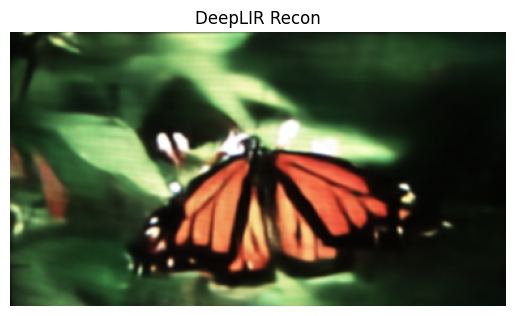

In [12]:
with torch.no_grad():
    inputs = image.to(my_device)
    output_test = model(inputs)

plt.imshow(preplot(output_test[0].cpu().detach().numpy()))
plt.axis('off')
plt.title('DeepLIR Recon')